# Klassifikation
Da mir lediglich Laptop-Lautsprecher und Laptop-Mikrofon zur verfügung stehen lassen sich leider keine gerichteten Audiosignale erzeugen und aufnehmen. Eine Objekterkennung wird daher vermutlich schwierig. 
Im folgenden versuche ich daher erst einmal das Echo in verschiedenen Räumen einzufangen und mit einem einfachen CNN zu erkennen in welchen Raum das Echo eingefangen wurde.

In [179]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pathlib
import numpy as np
import glob
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Daten-Pipeline erstellen

In [184]:
data_dir = pathlib.Path("data")
#list_ds = tf.data.Dataset.list_files(str(data_dir/'klo/*.png'))
list_ds = tf.data.Dataset.from_tensor_slices(glob.glob('data/*/*.png'))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
image_count = len(list(data_dir.glob('*/*.png')))

In [185]:
CLASS_NAMES

array(['schlafzimmer', 'kueche', 'klo', 'wohnzimmer'], dtype='<U12')

In [186]:
BATCH_SIZE = 8
IMG_HEIGHT = 400
IMG_WIDTH = 400
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [187]:

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [262]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(8)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [263]:
full_dataset  = list_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(50000,reshuffle_each_iteration=False)
#train_ds = prepare_for_training(full_dataset)
#full_dataset = (full_dataset.map(normalize).shuffle(50000).batch(128, drop_remainder=True))#
#
train_dataset = prepare_for_training(full_dataset.take(int(image_count*0.6)))
test_dataset = prepare_for_training(full_dataset.skip(int(image_count*0.6)))

In [397]:
testing=prepare_for_training(full_dataset.take(5))
for image, label in testing.take(1):
    #print("Image shape: ", image.numpy().shape)
    #print("Label: ", label.numpy())
    print("Label: ", label.numpy())


Label:  [[False False False  True]
 [False False  True False]
 [ True False False False]
 [False False  True False]
 [False False  True False]
 [False False  True False]
 [False False  True False]
 [ True False False False]]


## CNN-Architektur erstellen

In [269]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(8, 3, padding='same', activation='relu', input_shape=(400, 400,1),name="inputlayer"),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dropout(0.3),
    Dense(4, activation='softmax', name='output')
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (Conv2D)          (None, 400, 400, 8)       80        
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 200, 200, 16)      1168      
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 50, 50, 64)      

In [270]:
model.compile(
        optimizer='adam',
        loss=['categorical_crossentropy'],
        metrics=['accuracy']
    )

In [271]:
history=model.fit(train_dataset,epochs=25,validation_data=test_dataset,steps_per_epoch=30,validation_steps=30)

Train for 30 steps, validate for 30 steps
Epoch 1/25
30/30 [==============================] - 23s 769ms/step - loss: 8.8864 - accuracy: 0.2042 - val_loss: 6.4363 - val_accuracy: 0.2000
Epoch 2/25
30/30 [==============================] - 22s 724ms/step - loss: 4.9391 - accuracy: 0.2292 - val_loss: 3.6697 - val_accuracy: 0.2375
Epoch 3/25
30/30 [==============================] - 21s 710ms/step - loss: 2.9470 - accuracy: 0.2708 - val_loss: 2.3480 - val_accuracy: 0.2667
Epoch 4/25
30/30 [==============================] - 21s 709ms/step - loss: 2.0186 - accuracy: 0.3000 - val_loss: 1.6803 - val_accuracy: 0.2958
Epoch 5/25
30/30 [==============================] - 21s 708ms/step - loss: 1.6080 - accuracy: 0.3292 - val_loss: 1.4640 - val_accuracy: 0.2667
Epoch 6/25
30/30 [==============================] - 21s 704ms/step - loss: 1.3371 - accuracy: 0.4375 - val_loss: 1.2886 - val_accuracy: 0.4333
Epoch 7/25
30/30 [==============================] - 22s 741ms/step - loss: 1.1225 - accuracy: 0.5417

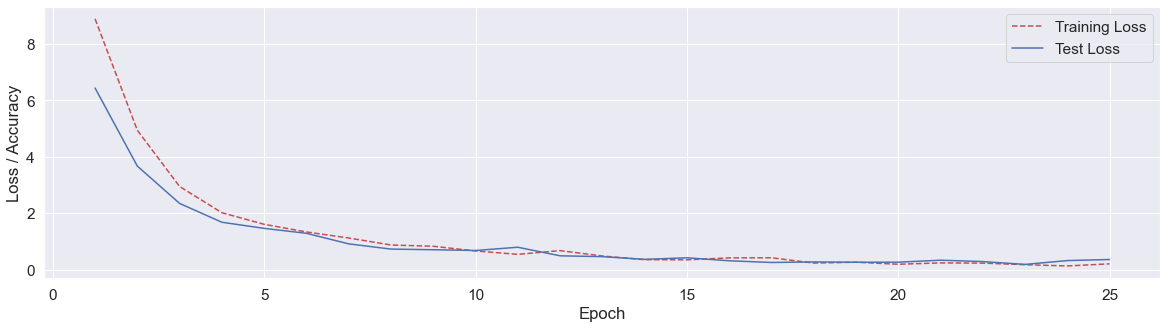

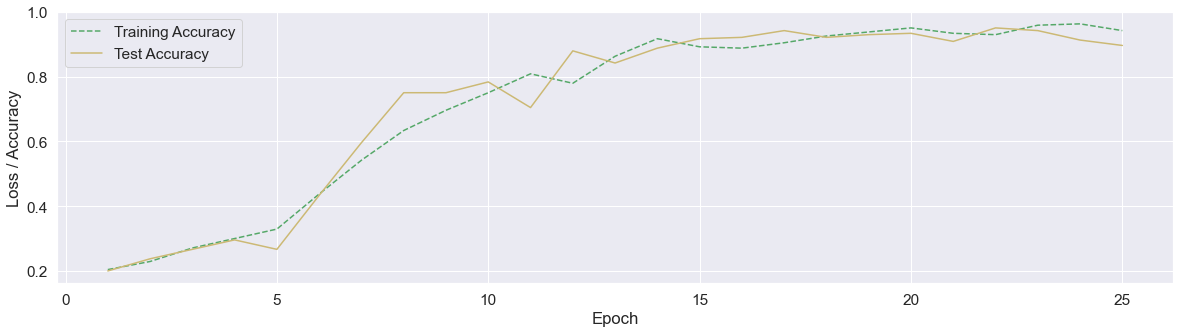

In [272]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss','training_accuracy','test_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_accuracy, 'g--')
plt.plot(epoch_count, test_accuracy, 'y-')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

In [273]:
true=[]
pred=[]

def classnumber(boollabel):
    for i,b in enumerate(boollabel):
        if b:return i

for images, labels in test_dataset.take(30):
    for index,image in enumerate(images):
        pred_temp=model.predict(tf.reshape(image,(1,400,400,1)))[0]
        pred_temp=(pred_temp.max(axis=0,) == pred_temp)
        true_temp=(labels[index].numpy())
        
        true.append(classnumber(true_temp))
        pred.append(classnumber(pred_temp))


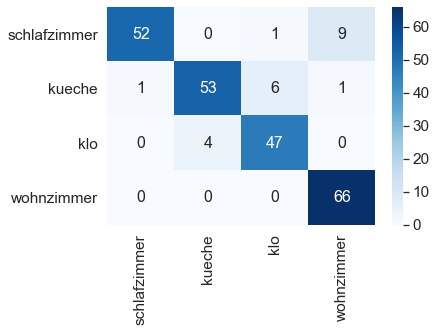

In [274]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(tf.math.confusion_matrix(true,pred).numpy(), CLASS_NAMES, CLASS_NAMES)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="d") # font size

plt.show()

## Live Testing

In [275]:
from PIL import Image
from matplotlib.pyplot import imshow
import os
import glob
import time
import sounddevice as sd
import numpy as np
import time
import librosa

def generate_new_echo(fs=96000,duration=0.1,f=25000):
    time.sleep(1)
    sine = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    samples=np.concatenate((sine, [0]*int(fs*duration)*2), axis=None)
    
    for i in range(2):
        samples=np.concatenate((samples, sine), axis=None)
        samples=np.concatenate((samples, [0]*int(fs*duration*2)), axis=None)


    rec=sd.playrec(samples,fs,channels=1)
    rec=rec.reshape((samples.shape[0]))[60050:87000]
    time.sleep(1)
    return rec


    
def img_from_audio(rec):
    
    D=np.abs(librosa.stft(rec,n_fft=2048,hop_length=64))
    DB=librosa.amplitude_to_db(D,ref=np.max)
    
    
    img=np.interp(DB[250:600,:400], (DB[250:600,:400].min(), DB[250:600,:400].max()), (0, 255))
    img = Image.fromarray(np.uint8(img) , 'L')
    img.save("temp.png")
    return img

wohnzimmer


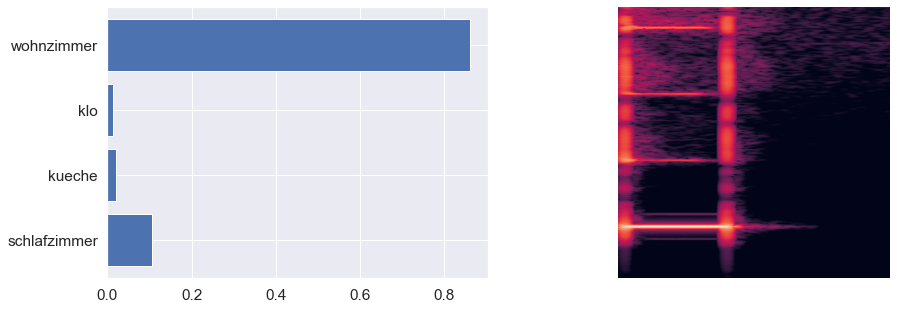

In [396]:
img=img_from_audio(generate_new_echo())

#print(CLASS_NAMES)
img = tf.io.read_file("temp.png")
#img = tf.io.read_file("data/schlafzimmer/100.png")
img = decode_img(img)
print(CLASS_NAMES[np.argmax(model.predict(tf.reshape(img,(1,400,400,1))))])

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[1].imshow(img.numpy().reshape(400,400))
axs[1].set_axis_off()
axs[0].barh([0,1,2,3],model.predict(tf.reshape(img,(1,400,400,1)))[0], align='center')
axs[0].set_yticks([0,1,2,3])
axs[0].set_yticklabels(CLASS_NAMES)
plt.show()

## Fazit
Die ersten Ergebnisse sind sehr zufriedenstellend. Beim Live-Testing des trainierten Netzes konnte ich feststellen, das es dem CNN schwer fällt, die Küche richtig zu erkennen. 

Nach weiteren Experimenten stellte ich fest, dass die KI fast immer den richtigen Raum erkennt, vorrausgesetzt der Laptop steht nahe der Stelle stellt, an der die Trainingsdaten erzeugt wurden.

Dies ist im nachhinein auch nicht verwunderlich, da ich den Laptop beim aufzeichnen der Trainingsdaten nie vom Fleck bewegt habe. Ich habe lediglich versucht möglichst verschiedene Szenarien zu erzeugen (Musik,Spülmaschine,Stille,Fenster auf usw.)

Ein spannende TODOS wäre nun mehr Trainingsdaten mit noch größerer Varianz zu erzeugen. Diesmal aber nicht nur Varianz in Umgebungsgeräuschen sondern auch Varianz der Aufnahme-Position im Zimmer. Weiter wäre es spannend zu erfahren, welche Auswirkungen eine höhere Sample Rate hätte!